## Notebook to reproduce the plots of PET denoising training performances and landmark placement performance on test set

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import nibabel as nib
import os
import seaborn as sns
import pandas as pd
from skimage.filters import threshold_otsu
sns.set_style('dark')

In [ ]:
# # mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/deanonymization_pet_reproducibility/notebooks

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/deanonymization_pet_reproducibility/notebooks


### Training perfs

In [ ]:
# load train and val perfs
train_loss_folds = np.load("../data/training_metrics/train_perfs.npy", allow_pickle=True).item()
val_loss_folds = np.load("../data/training_metrics/val_perfs.npy", allow_pickle=True).item()
train_loss_folds.keys(), val_loss_folds.keys()

(dict_keys([0, 1, 2, 3, 4]), dict_keys([0, 1, 2, 3, 4]))

In [ ]:
# store in dataframes
df_train_loss = pd.DataFrame.from_dict(train_loss_folds)
df_val_loss = pd.DataFrame.from_dict(val_loss_folds)
df_train_loss['epoch'] = df_train_loss.index
df_val_loss['epoch'] = df_val_loss.index

In [ ]:
df_train_loss = df_train_loss.melt(id_vars=['epoch'], value_vars=df_train_loss.columns[:-1],
                   value_name='Loss',
                   var_name='Fold')

df_train_loss['Type'] = 'Train'


df_val_loss = df_val_loss.melt(id_vars=['epoch'],
                               value_vars=df_val_loss.columns[:-1],
                   value_name='Loss',
                   var_name='Fold')

df_val_loss['Type'] = 'Validation'

df_loss = pd.concat([df_train_loss, df_val_loss])
df_loss.reset_index(inplace=True)

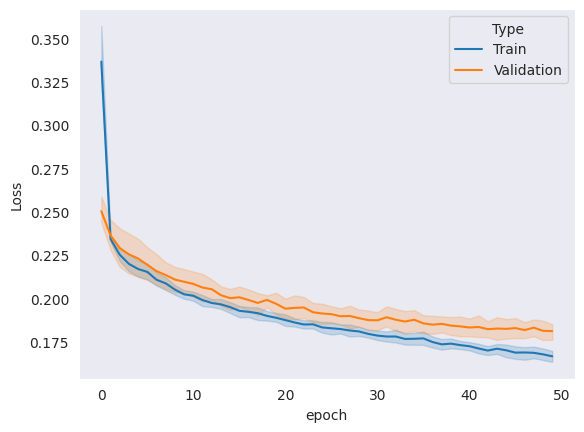

In [ ]:
sns.lineplot(data=df_loss,
             x='epoch',
             y='Loss',
             hue='Type')
plt.savefig('../docs/denoising/train_val_loss_5_fold.png', dpi=300)
plt.show()

### Plot distribution of MAD between landmarks placed on PET VS on CT

In [ ]:
# define relevant parameters for plots
thresh_mad = 15

In [ ]:
test_perfs = np.load("../data/training_metrics/test_perfs.npy", allow_pickle=True).item()
test_perfs.keys()

dict_keys([0, 1, 2, 3, 4])

In [ ]:
test_perfs[0].keys()

dict_keys(['landmarks_pet', 'landmarks_pet_orig', 'landmarks_ct', 'MAD', 'MAD_orig'])

In [ ]:
df_MAD = pd.DataFrame()
df_MAD['MAD'] = np.hstack([test_perfs[i]["MAD"] + test_perfs[i]["MAD_orig"] for i in range(5)])
df_MAD['Denoised'] = np.hstack([[True]*len(test_perfs[i]["MAD"]) + [False]*len(test_perfs[i]["MAD_orig"]) for i in range(5)])
df_MAD['Fold'] = np.hstack([[i]*len(test_perfs[i]["MAD"]) + [i]*len(test_perfs[i]["MAD_orig"]) for i in range(5)])

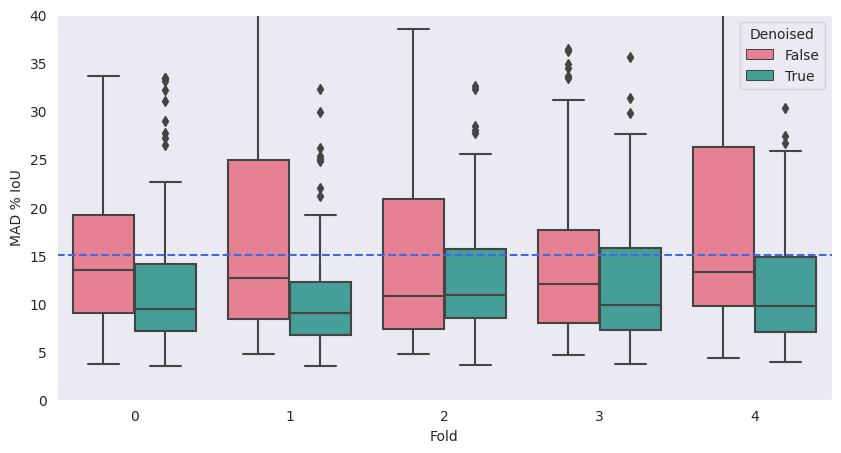

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_MAD,
            x='Fold', y='MAD', hue='Denoised', palette='husl', ax=ax)
ax.set(ylim=((0, 40)),
       ylabel='MAD % IoU')
ax.axhline(thresh_mad, c='royalblue', linestyle='--')
plt.savefig('../docs/denoising/mad_5_fold.png', dpi=300)
plt.show()

In [ ]:
# Get relevant statistics
## Mean of medians across folds of MAD
df_MAD.groupby(["Denoised", "Fold"])["MAD"].median().reset_index().groupby("Denoised")["MAD"].mean()

Denoised
False    12.410542
True      9.792855
Name: MAD, dtype: float64

In [ ]:
## Mean of std across folds of MAD
df_MAD.groupby(["Denoised", "Fold"])["MAD"].std().reset_index().groupby("Denoised")["MAD"].mean()

Denoised
False    27.057812
True      9.220606
Name: MAD, dtype: float64

### Plot quality of landmark placement and compare with non deep denoising approaches

In [ ]:
## sanity check to make sure all test sets have same size
fold_idx = np.load("../model_checkpoints/fold_splits.npy", allow_pickle=True).item()
sizes_test = [len(fold_idx[i]["test"]) for i in fold_idx]
assert len(np.unique(sizes_test)) == 1
sizes_test

[128, 128, 128, 128, 128]

In [ ]:
test_perfs_non_deep = np.load("../data/training_metrics/test_perfs_non_deep_denoising.npy", allow_pickle=True).item()

In [ ]:
df_lm = pd.DataFrame()
df_lm['perc_landmarks_PET_deep'] = [test_perfs[i]['landmarks_pet'] for i in range(5)]
df_lm['perc_landmarks_PET_nondeep'] = [test_perfs_non_deep[i]['landmarks_pet'] for i in range(5)]
df_lm['perc_landmarks_PET_orig'] = [test_perfs[i]['landmarks_pet_orig'] for i in range(5)]

df_lm['perc_landmarks_CT'] = [test_perfs[i]['landmarks_ct'] for i in range(5)]
df_lm['perc_landmarks_PET_deep_good'] = [np.sum(np.array(test_perfs[i]['MAD']) < thresh_mad) for i in range(5)]
df_lm['perc_landmarks_PET_nondeep_good'] = [np.sum(np.array(test_perfs_non_deep[i]['MAD']) < thresh_mad) for i in range(5)]
df_lm['perc_landmarks_PET_orig_good'] = [np.sum(np.array(test_perfs[i]['MAD_orig']) < thresh_mad) for i in range(5)]

df_lm /= sizes_test[0]
df_lm.columns = ['PET', 'PET(non deep)', 'PET_original', 'CT', 'PET_good', 'PET_good(non deep)', 'PET_original_good']
df_lm = df_lm.melt(value_vars=['PET',
                               'PET(non deep)',
                               'PET_original',
                               'CT',
                               'PET_good',
                               'PET_good(non deep)',
                               'PET_original_good'],
           value_name='Percentage',
           var_name='Type')


In [ ]:
df_lm

,Type,Percentage
0,PET,0.812500
1,PET,0.828125
2,PET,0.757812
3,PET,0.851562
4,PET,0.828125
5,PET(non deep),0.507812
6,PET(non deep),0.484375
7,PET(non deep),0.398438
8,PET(non deep),0.492188
9,PET(non deep),0.460938


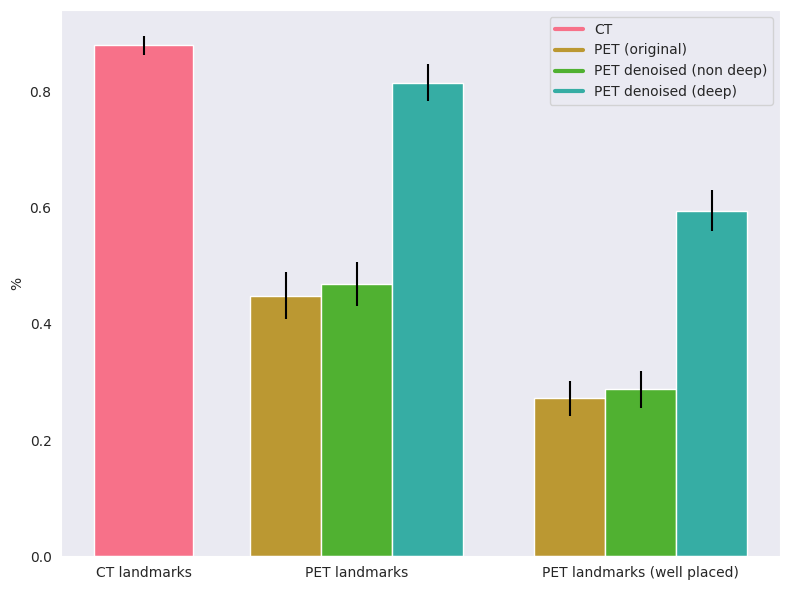

In [ ]:
palette = sns.color_palette('husl')

ct_perc = df_lm.loc[df_lm["Type"] == "CT", "Percentage"]
pet_orig_perc = df_lm.loc[df_lm['Type'] == "PET_original", "Percentage"]
pet_perc = df_lm.loc[df_lm['Type'] == "PET", "Percentage"]
pet_non_deep_perc = df_lm.loc[df_lm['Type'] == "PET(non deep)", "Percentage"]


good_pet_orig_perc = df_lm.loc[df_lm['Type'] == "PET_original_good", "Percentage"]
good_pet_perc = df_lm.loc[df_lm['Type'] == "PET_good", "Percentage"]
good_pet_non_deep_perc = df_lm.loc[df_lm['Type'] == "PET_good(non deep)", "Percentage"]


height = [np.mean(ct_perc),
          np.mean(pet_orig_perc),
          np.mean(pet_non_deep_perc),
          np.mean(pet_perc),
          np.mean(good_pet_orig_perc),
          np.mean(good_pet_non_deep_perc),
          np.mean(good_pet_perc),
          ]

bars = ['CT landmarks',
        'PET landmarks',
        'PET landmarks (well placed)',
       ]

errors = [np.std(ct_perc),
          np.std(pet_orig_perc),
          np.std(pet_non_deep_perc),
          np.std(pet_perc),
          np.std(good_pet_orig_perc),
          np.std(good_pet_non_deep_perc),
          np.std(good_pet_perc),
          ]

x_pos = [0., 1., 1.5, 2, 3, 3.5, 4]
x_pos_labels = [0, 1.5, 3.5]

# create legend
lines = [Line2D([0], [0], color=c, linewidth=3) for c in palette[:4]]
legend_labels = ["CT", "PET (original)", "PET denoised (non deep)", "PET denoised (deep)"]

sns.set_style('dark')
plt.figure(figsize=(8,6))
plt.bar(x_pos, height,
        color=[palette[0]]+palette[1:4]*2,
        width=[.7, .5, .5, .5, .5, .5, .5],
        yerr=errors)

plt.xticks(x_pos_labels, bars)
plt.ylabel('%')
plt.legend(lines, legend_labels, loc="upper right")
plt.tight_layout()
plt.savefig("../docs/denoising/landmarks_well_placed_5folds_with_non_deep_denoising.png", dpi=300)
plt.show()

In [ ]:
height

[0.8796875, 0.4484375, 0.46875, 0.815625, 0.271875, 0.2875, 0.5953125]

In [ ]:
errors

[0.016086922095292187,
 0.04032339968926231,
 0.038273277230987154,
 0.031483502624390446,
 0.03021731188408393,
 0.031792171795899694,
 0.03472829807952011]